# Implementing Adadelta from scratch

- A limitation of gradient descent is that it uses the same step size (learning rate) for each input variable.
    AdaGradn and RMSProp are extensions to gradient descent that add a self-adaptive learning rate for 
- each parameter for the objective function.

Adadelta can be considered a further extension of gradient descent that builds upon AdaGrad and RMSProp and changes the calculation of the custom step size so that the units are consistent and in turn no longer requires an
initial learning rate hyperparameter.

In [1]:
# Importing the necessary libraries

from numpy import arange
from numpy import meshgrid
from matplotlib import pyplot
from numpy import asarray
from numpy.random import rand
from numpy.random import seed
from math import sqrt


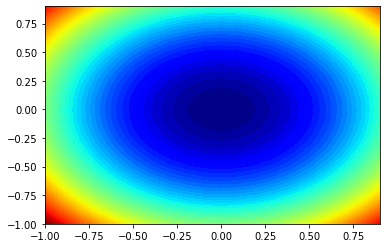

In [2]:
# Objective function and its visualisation



# objective function
def objective(x, y):
    return x**2.0 + y**2.0
 
# define range for input
bounds = asarray([[-1.0, 1.0], [-1.0, 1.0]])
# sample input range uniformly at 0.1 increments
xaxis = arange(bounds[0,0], bounds[0,1], 0.1)
yaxis = arange(bounds[1,0], bounds[1,1], 0.1)
# create a mesh from the axis
x, y = meshgrid(xaxis, yaxis)
# compute targets
results = objective(x, y)
# create a filled contour plot with 50 levels and jet color scheme
pyplot.contourf(x, y, results, levels=50, cmap='jet')
# show the plot
pyplot.show()















# How does adagrad work

## Adagrad pseudocode

- First, the custom step size is calculated as the square root of the decaying moving average of the change in the delta divided by the square root of the decaying moving average
    of the squared partial derivatives.
    cust_step_size(t+1) = (ep + sqrt(delta(t))) / (ep + sqrt(s(t)))
    Where cust_step_size(t+1) is the custom step size for a parameter for a given update,
- ep is a hyperparameter that is added to the numerator and denominator to avoid a divide by zero error,
- delta(t) is the decaying moving average of the squared change to the parameter (calculated in the last iteration), and 
- s(t) is the decaying moving average of the squared partial derivative (calculated in the current iteration).

### Next, the change to the parameter is calculated as the custom step size multiplied by the partial derivative
change(t+1) = cust_step_size(t+1) * f'(x(t))

### Next, the decaying average of the squared change to the parameter is updated.
delta(t+1) = (delta(t) * rho) + (change(t+1)^2 * (1.0-rho))
Where delta(t+1) is the decaying average of the change to the variable to be used in the next iteration, change(t+1) was calculated in the step before and rho is a hyperparameter that acts like momentum and has a value like 0.9.

### Finally, the new value for the variable is calculated using the change.
x(t+1) = x(t) – change(t+1)

This process is then repeated for each variable for the objective function, then the entire process is repeated to
navigate the search space for a fixed number of algorithm iterations.

In [3]:
# Implementing ada delta algorithm


# derivative of the objective function

def derivative(x, y):
    return asarray([x * 2.0, y * 2.0])

def adadelta(objective, derivative, bounds, n_iter, rho, ep=1e-3):
    # generate an initial point
    solution = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
    # list of the average square gradients for each variable
    sq_grad_avg = [0.0 for _ in range(bounds.shape[0])]
    # list of the average parameter updates
    sq_para_avg = [0.0 for _ in range(bounds.shape[0])]
    # run the gradient descent
    for it in range(n_iter):
        # calculate gradient
        gradient = derivative(solution[0], solution[1])
        # update the average of the squared partial derivatives
        for i in range(gradient.shape[0]):
            # calculate the squared gradient
            sg = gradient[i]**2.0
            # update the moving average of the squared gradient
            sq_grad_avg[i] = (sq_grad_avg[i] * rho) + (sg * (1.0-rho))
        # build a solution one variable at a time
        new_solution = list()
        for i in range(solution.shape[0]):
            # calculate the step size for this variable
            alpha = (ep + sqrt(sq_para_avg[i])) / (ep + sqrt(sq_grad_avg[i]))
            # calculate the change
            change = alpha * gradient[i]
            # update the moving average of squared parameter changes
            sq_para_avg[i] = (sq_para_avg[i] * rho) + (change**2.0 * (1.0-rho))
            # calculate the new position in this variable
            value = solution[i] - change
            # store this variable
            new_solution.append(value)
        # evaluate candidate point
        solution = asarray(new_solution)
        solution_eval = objective(solution[0], solution[1])
        # report progress
        print('>%d f(%s) = %.5f' % (it, solution, solution_eval))
    return [solution, solution_eval]

    


In [4]:
# seed the pseudo random number generator

#seed the pseudo random number generator
seed(1)
# define range for input
bounds = asarray([[-1.0, 1.0], [-1.0, 1.0]])
# define the total iterations
n_iter = 120
# momentum for adadelta
rho = 0.99
# perform the gradient descent search with adadelta
best, score = adadelta(objective, derivative, bounds, n_iter, rho)
print('Done!')
print('f(%s) = %f' % (best, score))

>0 f([-0.15624846  0.43076118]) = 0.20997
>1 f([-0.14299468  0.41693563]) = 0.19428
>2 f([-0.12914643  0.40184605]) = 0.17816
>3 f([-0.11566994  0.38630269]) = 0.16261
>4 f([-0.10299941  0.37069192]) = 0.14802
>5 f([-0.09132837  0.35523116]) = 0.13453
>6 f([-0.08072226  0.34005317]) = 0.12215
>7 f([-0.07117441  0.32524231]) = 0.11085
>8 f([-0.06263776  0.31085275]) = 0.10055
>9 f([-0.05504377  0.29691871]) = 0.09119
>10 f([-0.04831412  0.28346065]) = 0.08268
>11 f([-0.04236781  0.27048927]) = 0.07496
>12 f([-0.03712545  0.25800822]) = 0.06795
>13 f([-0.03251183  0.24601593]) = 0.06158
>14 f([-0.02845711  0.234507  ]) = 0.05580
>15 f([-0.02489748  0.22347322]) = 0.05056
>16 f([-0.02177521  0.21290424]) = 0.04580
>17 f([-0.01903851  0.20278822]) = 0.04149
>18 f([-0.01664114  0.19311222]) = 0.03757
>19 f([-0.01454205  0.18386255]) = 0.03402
>20 f([-0.01270485  0.17502504]) = 0.03080
>21 f([-0.01109744  0.16658525]) = 0.02787
>22 f([-0.00969149  0.15852865]) = 0.02523
>23 f([-0.00846208  0